# Data Exploration


## Set up


In [1]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

from src import process
from src import plot

# Update the combined-results-<i>-*.csv file if new data added to ./data/raw/
process.combine_raw_results()

# Load processed data frame
# If process.process_combined_results() is modified, then force_update=True is necessary
# to overwrite the existing processed results file
df = process.load_processed_results(force_update=True)

display(df.tail())

,id,is_pb,wpm,acc,raw_wpm,consistency,char_stats,mode,mode2,quote_length,...,iti_all,iti_session,time_since_last_new_sesh,combined_id,trial_type_id,z_wpm,z_acc,trial_num,trial_type_num,log_norm_wpm
1823,65940c8ea65b7d25a1993863,0,33.2,96.80,33.2,60.01,"332,0,0,0",time,120,-1,...,18.0,18.0,138000,29,2,1.445331,1.029419,1824,358,7.839566
1824,65940d16a65b7d25a1993e31,0,31.0,91.20,31.0,61.47,"310,0,0,0",time,120,-1,...,16.0,16.0,274000,29,2,0.914677,-0.514066,1825,359,6.796597
1825,65955ea2a65b7d25a1a4b674,0,33.5,95.99,33.5,63.41,"335,0,0,0",time,120,-1,...,86292.0,NaN,0,29,2,1.517693,0.806165,1826,360,7.981789
1826,65955f2ea65b7d25a1a4bc77,0,33.4,95.20,33.4,62.92,"334,0,0,0",time,120,-1,...,20.0,20.0,140000,29,2,1.493572,0.588423,1827,361,7.934381
1827,65955faba65b7d25a1a4c20f,0,29.7,90.91,29.7,58.77,"297,0,0,0",time,120,-1,...,5.0,5.0,0,29,2,0.601110,-0.593997,1828,362,6.180298


## Visualization of all trials


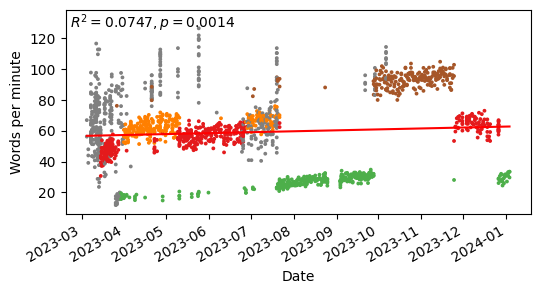

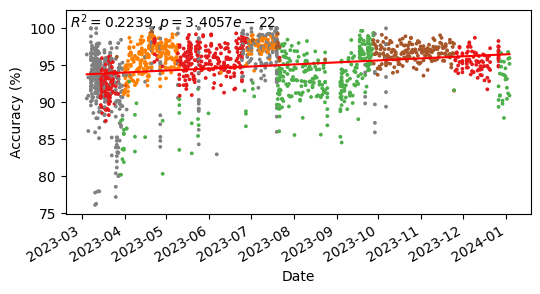

In [3]:
# WPM of all trials across all time
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "datetime", "wpm", plot_regression=True, s=3, n_colors=5)
plt.show()

# Acc of all trials across all time
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "datetime", "acc", plot_regression=True, s=3, n_colors=5)
plt.show()

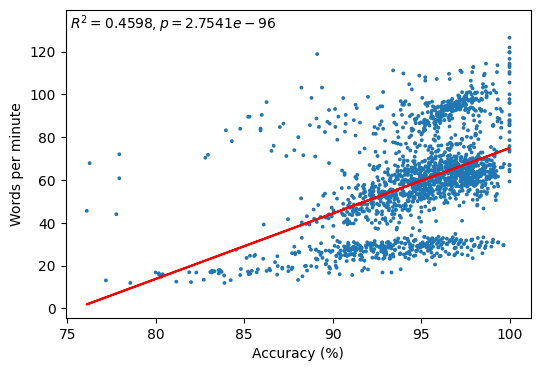

In [4]:
# Correlation between wpm and acc
fig = plt.figure(figsize=(6, 4))
ax = plot.df_scatter(df, "acc", "wpm", plot_regression=True, s=3)
plt.show()

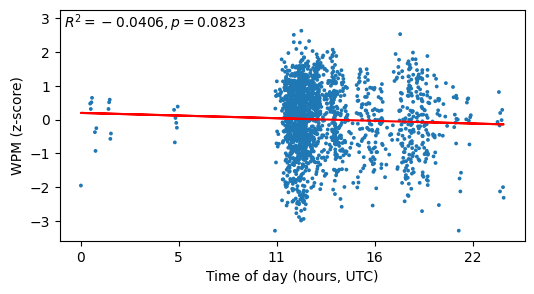

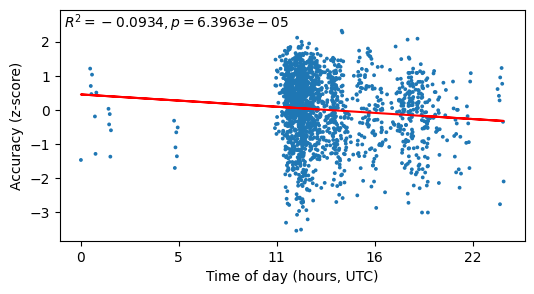

In [5]:
# Correlation between time_of_day_sec and z_wpm
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "time_of_day_sec", "z_wpm", plot_regression=True, s=3)
plt.show()

# Correlation between time_of_day_sec and z_acc
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "time_of_day_sec", "z_acc", plot_regression=True, s=3)
plt.show()

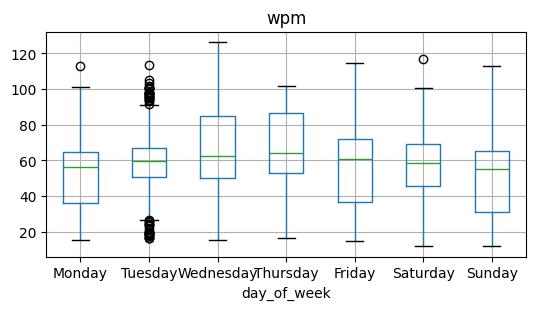

ANOVA: F-statistic = 10.24, p-value = 3.56e-11


In [6]:
feature = "wpm"
# Violin plot of wpm grouped by day of week
df.boxplot(column=feature, by="day_of_week", figsize=(6, 3))
plt.suptitle("")
plt.show()

# Compare the mean wpm for each day of the week with a 1-way ANOVA
groups = df.groupby("day_of_week", observed=True)[feature].apply(list)
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA: F-statistic = {f_stat:.2f}, p-value = {p_value:.2e}")

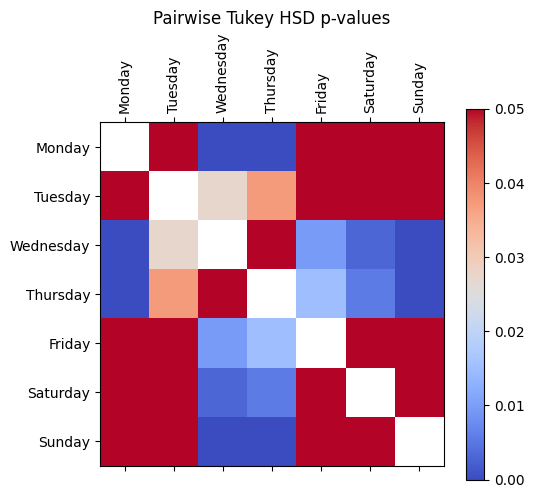

group1,group2,meandiff,p-adj,lower,upper,reject
Friday,Monday,-3.7872,0.4876,-9.7036,2.1291,False
Friday,Saturday,-0.6389,0.9999,-6.5015,5.2236,False
Friday,Sunday,-4.4786,0.2876,-10.4457,1.4885,False
Friday,Thursday,6.915,0.0151,0.7995,13.0306,True
Friday,Tuesday,0.6488,0.9999,-5.1207,6.4183,False
Friday,Wednesday,6.4688,0.0097,0.9598,11.9779,True
Monday,Saturday,3.1483,0.7068,-2.8016,9.0982,False
Monday,Sunday,-0.6914,0.9999,-6.7443,5.3615,False
Monday,Thursday,10.7023,0.0,4.503,16.9016,True
Monday,Tuesday,4.436,0.2771,-1.4222,10.2942,False


In [7]:
# Plot a matrix of pairwise p-values from the tukey result

# Perform the Tukey HSD test
tukey = pairwise_tukeyhsd(df["wpm"], df["day_of_week"], alpha=0.05)

# Create matrix of all pairwise p-values
groups = tukey.groupsunique
matrix_size = len(groups)
pvalue_matrix = np.full((matrix_size, matrix_size), np.nan)
group_indices = {group: index for index, group in enumerate(groups)}
# Fill the matrix
for result in tukey.summary().data[1:]:  # Skip the header row
    group1, group2 = result[0], result[1]
    pvalue = result[3]
    idx1, idx2 = group_indices[group1], group_indices[group2]
    pvalue_matrix[idx1, idx2] = pvalue
    pvalue_matrix[idx2, idx1] = pvalue
sorted_indices = [
    group_indices[day]
    for day in [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
]
pvalue_matrix = pvalue_matrix[sorted_indices, :][:, sorted_indices]
fig = plt.figure(figsize=(5.5, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(pvalue_matrix, cmap="coolwarm")
fig.colorbar(cax)
ax.set_xticks(np.arange(matrix_size))
ax.set_yticks(np.arange(matrix_size))
ax.set_xticklabels(groups[sorted_indices], rotation=90)
ax.set_yticklabels(groups[sorted_indices], rotation=0)
plt.title("Pairwise Tukey HSD p-values")
plt.tight_layout()
cax.set_clim(0, 0.05)
plt.show()

tukey.summary()

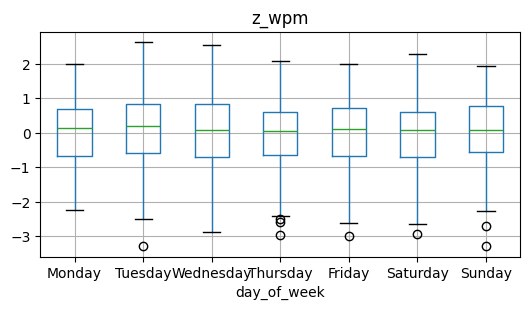

ANOVA: F-statistic = 0.83, p-value = 5.45e-01


In [8]:
feature = "z_wpm"
# Violin plot of wpm grouped by day of week, sorted by Monday to Sunday
df.boxplot(column=feature, by="day_of_week", figsize=(6, 3))
plt.suptitle("")
plt.show()

# Compare the mean wpm for each day of the week with a 1-way ANOVA
groups = df.groupby("day_of_week", observed=True)[feature].apply(list)
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA: F-statistic = {f_stat:.2f}, p-value = {p_value:.2e}")

## Analysis Within and across sessions


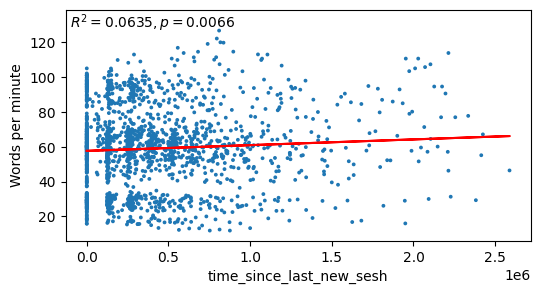

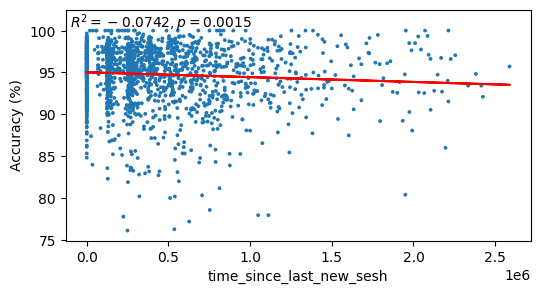

In [9]:
# Correlation between time_since_last_new_sesh and wpm
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(
    df, "time_since_last_new_sesh", "wpm", plot_regression=True, s=3
)  # datetime
plt.show()

# Correlation between time_since_last_new_sesh and acc
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(
    df, "time_since_last_new_sesh", "acc", plot_regression=True, s=3
)  # datetime
plt.show()

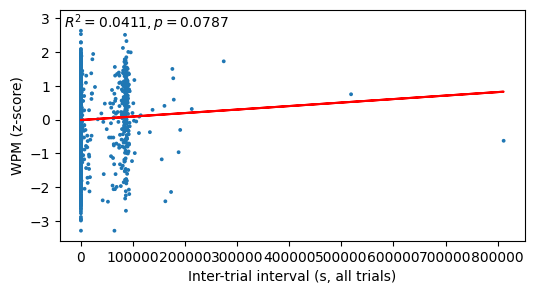

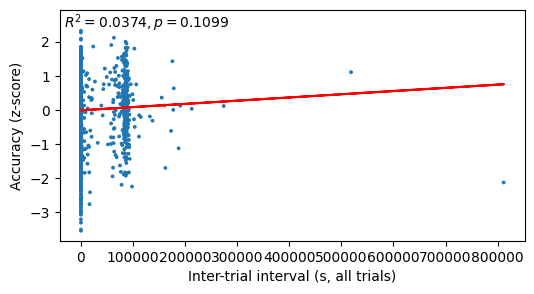

In [10]:
# Z-scored WPM as a function of all inter-trial intervals (ITI)
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "iti_all", "z_wpm", plot_regression=True, s=3)
plt.show()

# Z-scored Acc as a function of all inter-trial intervals (ITI)
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "iti_all", "z_acc", plot_regression=True, s=3)
plt.show()

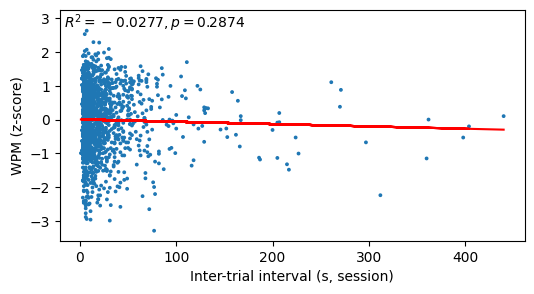

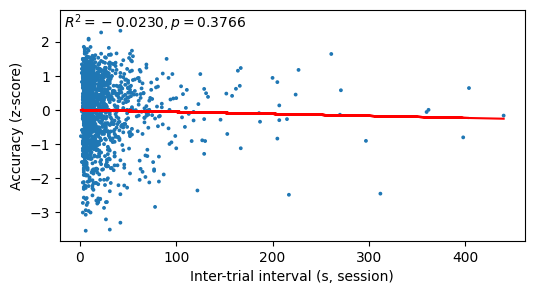

In [11]:
# Z-scored WPM as a function of inter-trial interval (ITI) within a session
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "iti_session", "z_wpm", plot_regression=True, s=3)
plt.show()

# Z-scored Acc as a function of inter-trial interval (ITI) within a session
fig = plt.figure(figsize=(6, 3))
ax = plot.df_scatter(df, "iti_session", "z_acc", plot_regression=True, s=3)
plt.show()

## Performance autocorrelation


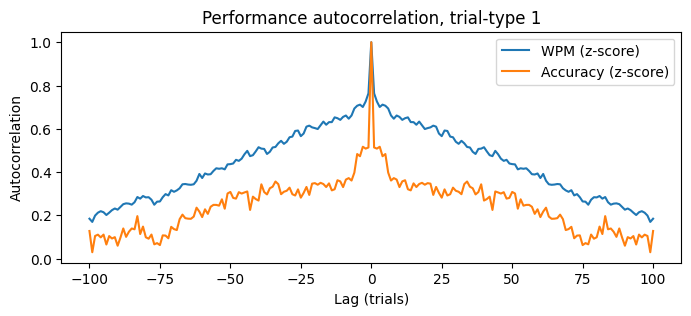

In [12]:
# Trial WPM/Acc autocorrelations for one trial type
fig = plt.figure(figsize=(8, 3))
ax = plot.performance_autocorrelation(df, trial_type_id=1)
plt.show()

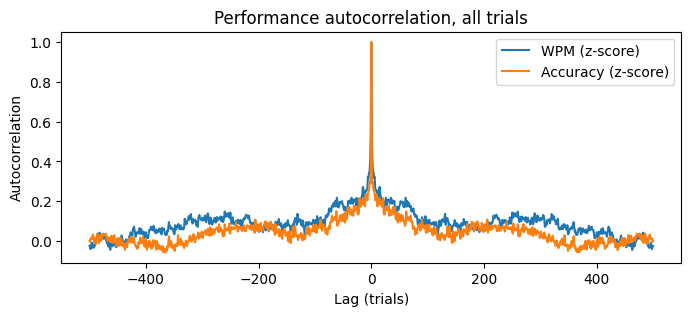

In [13]:
# Trial WPM/Acc autocorrelations for all trials
n_lags = 500
fig = plt.figure(figsize=(8, 3))
ax = plot.performance_autocorrelation(df, trial_type_id=None, n_lags=n_lags)
plt.show()

## Performance split by trial properties


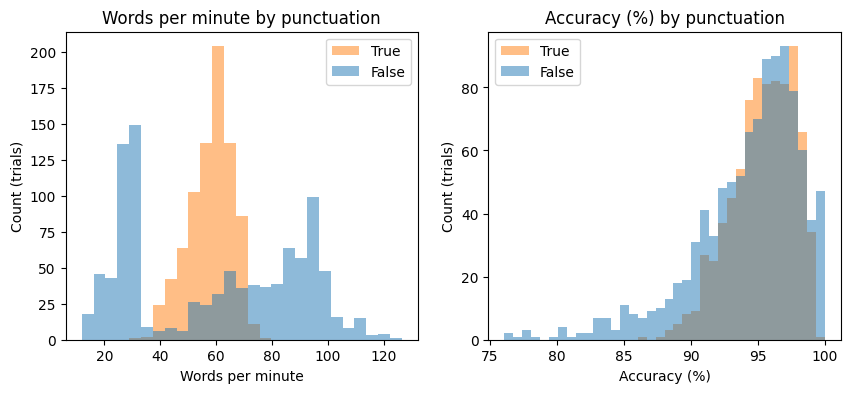

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot.histogram_by_type(df, "wpm", "punctuation", ax=ax[0])
plot.histogram_by_type(df, "acc", "punctuation", ax=ax[1])
plt.show()

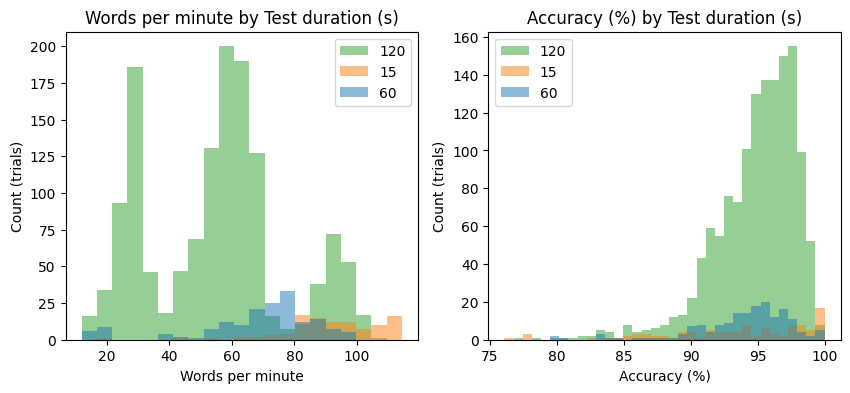

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot.histogram_by_type(df, "wpm", "test_duration", ax=ax[0])
plot.histogram_by_type(df, "acc", "test_duration", ax=ax[1])
plt.show()